# Goals

* Summarize the tissues and tissue categorizations

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
from pypika import Query, Table, Field, Column, Criterion

In [3]:
from SRAgent.db.connect import db_connect
from SRAgent.db.utils import db_list_tables

In [4]:
# set plotnine theme to bw
pn.theme_set(pn.theme_bw())

In [5]:
# set to prod database
os.environ['DYNACONF'] = 'prod'

In [ ]:
# get base of git repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

In [7]:
# list database tables
with db_connect() as conn:
    print("\n".join(db_list_tables(conn)))

eval
screcounter_star_results
scbasecamp_metadata
screcounter_trace
srx_srr
srx_metadata
screcounter_log
scbasecamp_metadata_tmp
screcounter_star_params


# Load

In [8]:
# load database metadata
tbl1 = Table("srx_metadata")
tbl2 = Table("screcounter_star_results")

# Create a subquery for distinct SRX accessions from screcounter_star_results.
## Just datasets that have STAR results.
subquery = Query.from_(tbl2).select(tbl2.sample).distinct()

stmt = (
    Query
    .from_(tbl1)
    .select(
        tbl1.srx_accession, tbl1.organism, tbl1.tissue, tbl1.tissue_ontology_term_id,
        tbl1.lib_prep, tbl1.tech_10x, tbl1.czi_collection_id
    )
    .where(tbl1.srx_accession.isin(subquery))
)

with db_connect() as conn:
    df_srx_meta = pd.read_sql(str(stmt), conn)
df_srx_meta

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None
...,...,...,...,...,...,...,...
61572,NRX0000732,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None
61573,NRX0000733,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None
61574,NRX0000734,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None
61575,NRX0000735,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None


In [9]:
# format the data
df_srx_meta["tech_10x"] = df_srx_meta.apply(
    lambda x: "other" if x["lib_prep"] != "10x_Genomics" else x["tech_10x"], axis=1
)
df_srx_meta["lib_prep"] = "10x_Genomics"
df_srx_meta

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None
...,...,...,...,...,...,...,...
61572,NRX0000732,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None
61573,NRX0000733,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None
61574,NRX0000734,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None
61575,NRX0000735,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None


In [11]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
2,3 layer spheroid channel 2,other
3,3D healthy skin model,skin of body
4,A549 cells,lung
...,...,...
15540,zebrafish explants,other
15541,"zebrafish heads, cranial neural crest-derived ...",head
15542,zebrafish larval intestine,intestine
15543,zebrafish larval intestines,intestine


In [12]:
# left join on tissue
df_srx_meta = df_srx_meta.merge(df_tissue_cats, on="tissue", how="left")
df_srx_meta

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id,category
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None,blood
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None,skin of body
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None,lung
...,...,...,...,...,...,...,...,...
61572,NRX0000732,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None,brain
61573,NRX0000733,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None,brain
61574,NRX0000734,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None,brain
61575,NRX0000735,Homo sapiens,neocortex,UBERON:0000955,10x_Genomics,3_prime_gex,None,brain


In [14]:
# number of tissue categories
df_tissue_cats["category"].nunique()

75

# Uberon accessions

In [12]:
# count records lacking tissue ontology term id
df_srx_meta[df_srx_meta["tissue_ontology_term_id"].isna() | (df_srx_meta["tissue_ontology_term_id"] == "") | (df_srx_meta["tissue_ontology_term_id"].str.strip() == "")].shape[0]

14286

In [13]:
# explode tissue ontology term id (split on ",")
df_srx_meta_exp = df_srx_meta.copy()
df_srx_meta_exp["tissue_ontology_term_id"] = df_srx_meta_exp["tissue_ontology_term_id"].str.split(",")
df_srx_meta_exp = df_srx_meta_exp.explode("tissue_ontology_term_id")
df_srx_meta_exp["tissue_ontology_term_id"] = df_srx_meta_exp["tissue_ontology_term_id"].apply(lambda x: "unknown" if x == "" else x)
df_srx_meta_exp

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id,category
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None,blood
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None,skin of body
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None,NaN
...,...,...,...,...,...,...,...,...
59551,SRX28094414,Mus musculus,small intestinal epithelium (duodenum crypt ep...,UBERON:0013482,10x_Genomics,3_prime_gex,None,NaN
59552,SRX28094411,Mus musculus,"ileal muscularis propria, duodenal crypt epith...",UBERON:0014390,10x_Genomics,3_prime_gex,None,NaN
59552,SRX28094411,Mus musculus,"ileal muscularis propria, duodenal crypt epith...",UBERON:0022280,10x_Genomics,3_prime_gex,None,NaN
59553,SRX28094413,Mus musculus,duodenal epithelium,UBERON:0008346,10x_Genomics,3_prime_gex,None,NaN


In [14]:
# count number of unique tissue ontology term ids
df_srx_meta_exp_cnt = df_srx_meta_exp.groupby("tissue_ontology_term_id").size().sort_values(ascending=False).to_frame().reset_index()
df_srx_meta_exp_cnt.columns = ["tissue_ontology_term_id", "count"]
df_srx_meta_exp_cnt

,tissue_ontology_term_id,count
0,unknown,11360
1,UBERON:0000178,6585
2,UBERON:0002371,3197
3,UBERON:0002048,3163
4,UBERON:0002107,2027
...,...,...
2014,UBERON:8600134,1
2015,UBERON:8700001,1
2016,UBERON:0000107,1
2017,UBERON:0000108,1


In [15]:
# get top 30 tissue ontology term ids
top30 = df_srx_meta_exp_cnt.head(30)["tissue_ontology_term_id"].to_list()
top30

['unknown',
 'UBERON:0000178',
 'UBERON:0002371',
 'UBERON:0002048',
 'UBERON:0002107',
 'UBERON:0002106',
 'UBERON:0000955',
 'UBERON:0001782',
 'UBERON:0002097',
 'UBERON:0000029',
 'UBERON:0002509',
 'UBERON:0002113',
 'UBERON:0001155',
 'UBERON:0001264',
 'UBERON:0000310',
 'UBERON:0007644',
 'UBERON:0000948',
 'UBERON:0000400',
 'UBERON:0035963',
 'UBERON:0001911',
 'UBERON:0000966',
 'UBERON:0002421',
 'UBERON:8600034',
 'UBERON:0002370',
 'UBERON:0000956',
 'UBERON:0000006',
 'UBERON:0001542',
 'UBERON:0002240',
 'UBERON:0002367',
 'UBERON:0002108']

In [16]:
import sys
sys.path.append(str(base_dir / 'scripts'))
from tissue_ontology_id2label import UberonAPILookup

In [17]:
lookup = UberonAPILookup()
id_label_map = lookup.lookup_batch(
    top30, delay=0.1, no_delay=False, show_progress=False
)
len(id_label_map)

Looking up 30 UBERON IDs...
Progress: 5/30 (16.7%)
Progress: 10/30 (33.3%)
Progress: 15/30 (50.0%)
Progress: 20/30 (66.7%)
Progress: 25/30 (83.3%)
Progress: 30/30 (100.0%)
Completed 30 lookups


30

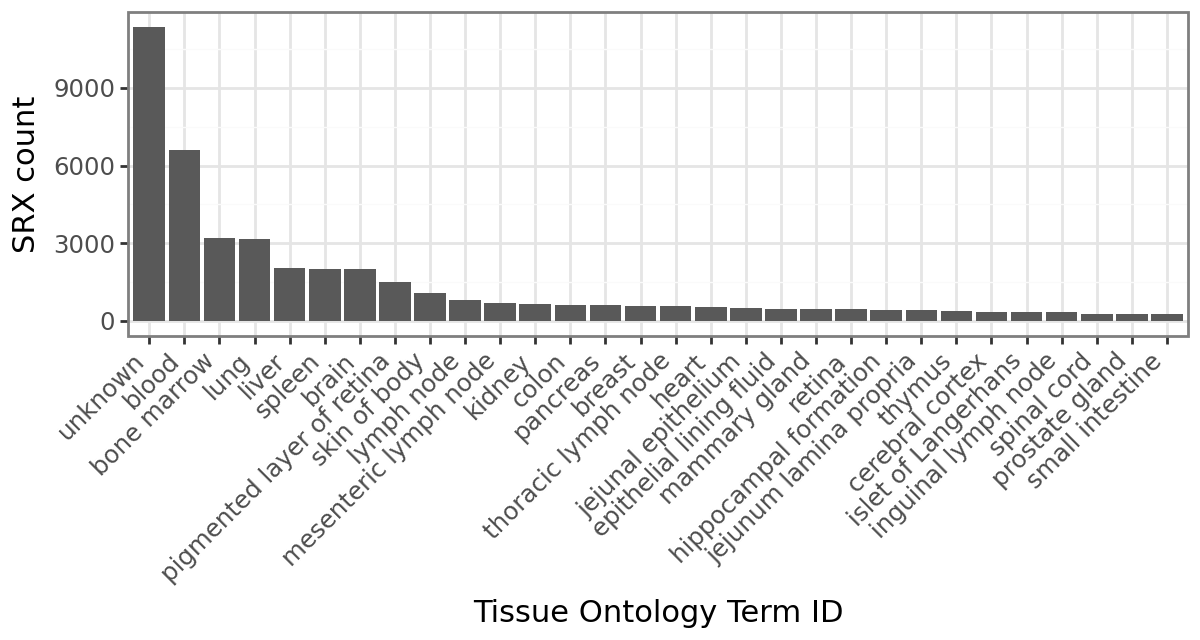

In [18]:
# plot histogram of top 30 tissue ontology term ids
## filter to top 30 categories
top30 = df_srx_meta_exp_cnt.head(30)["tissue_ontology_term_id"].to_list()
df = df_srx_meta_exp[df_srx_meta_exp["tissue_ontology_term_id"].isin(top30)].copy()
df["tissue_ontology_term_id"] = df["tissue_ontology_term_id"].to_list()

## order category by count
df["tissue_ontology_term_id"] = pd.Categorical(
    df["tissue_ontology_term_id"], 
    categories=df["tissue_ontology_term_id"].value_counts().index
)
# add tissue ontology term label 
df["tissue_ontology_term_label"] = df["tissue_ontology_term_id"].map(id_label_map)

# plot
p = (
    pn.ggplot(df, pn.aes(x="tissue_ontology_term_label")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Ontology Term ID", y="SRX count") +
    pn.theme(
        axis_text_x=pn.element_text(angle=45, hjust=1),
        figure_size=(6, 3.2)
    )
)
p

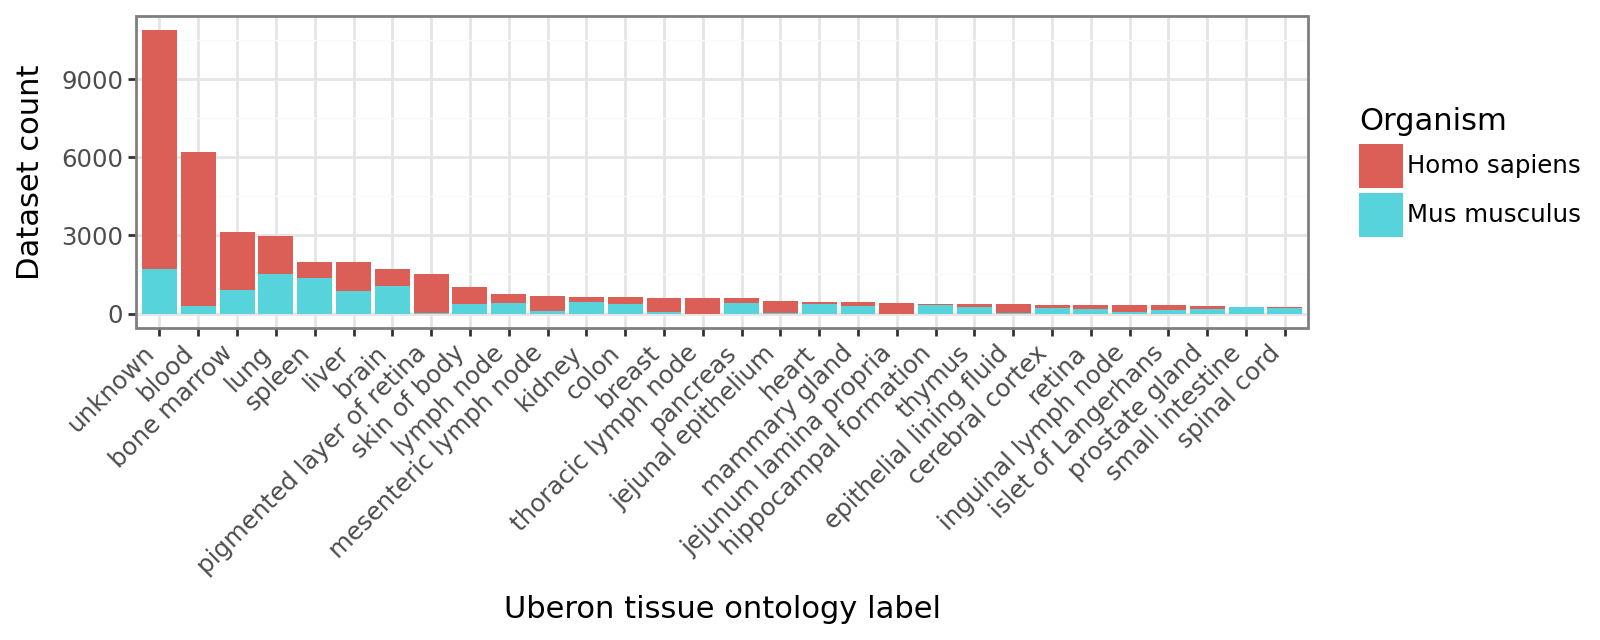

In [26]:
# plot histogram of top 30 tissue ontology term ids
## filter to top 30 categories
top30 = df_srx_meta_exp_cnt.head(30)["tissue_ontology_term_id"].to_list()
df = df_srx_meta_exp[df_srx_meta_exp["tissue_ontology_term_id"].isin(top30)].copy()
df["tissue_ontology_term_id"] = df["tissue_ontology_term_id"].to_list()

# filter to human and mouse
df = df[df["organism"].isin(["Homo sapiens", "Mus musculus"])]

# add tissue ontology term label
df["tissue_ontology_term_label"] = df["tissue_ontology_term_id"].map(id_label_map)

## order category by count
df["tissue_ontology_term_label"] = pd.Categorical(
    df["tissue_ontology_term_label"], 
    categories=df["tissue_ontology_term_label"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="tissue_ontology_term_label", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Uberon tissue ontology label", y="Dataset count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(angle=45, hjust=1),
        figure_size=(8, 3.2)
    )
)
p

# Cell x Gene tissue categories

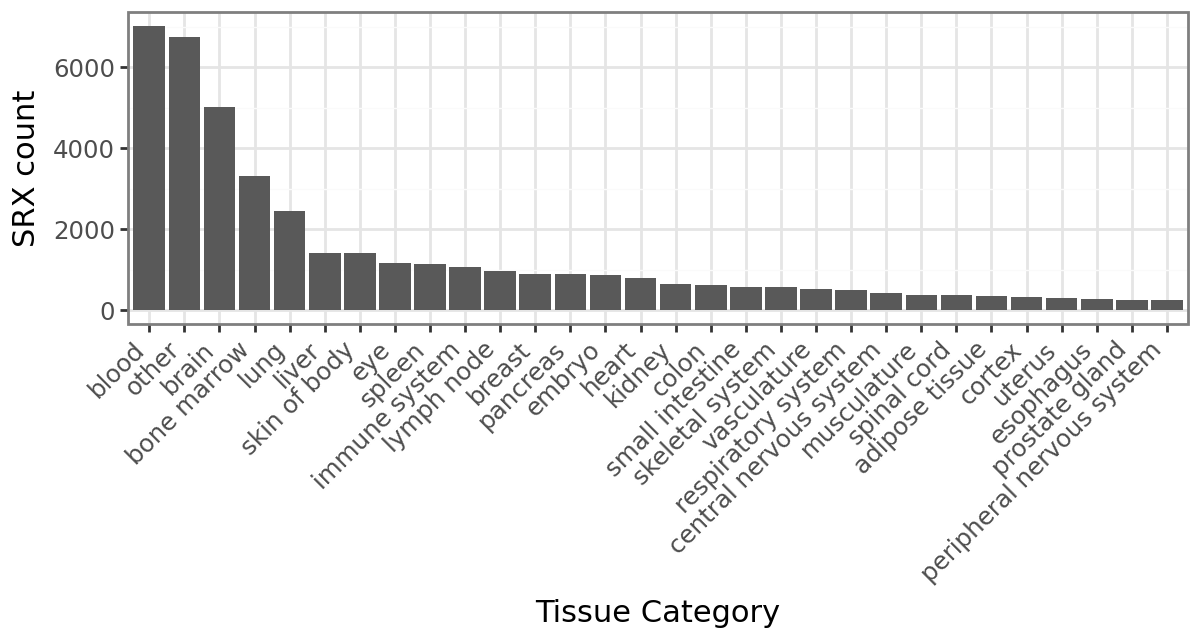

In [27]:
# plot histogram of tissue categories
## filter to top 30 categories
top30 = df_srx_meta["category"].value_counts().head(30).index
df = df_srx_meta[df_srx_meta["category"].isin(top30)].copy()
df["category"] = df["category"].to_list()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count") +
    pn.theme(
        axis_text_x=pn.element_text(angle=45, hjust=1),
        figure_size=(6, 3.2)
    )
)
p

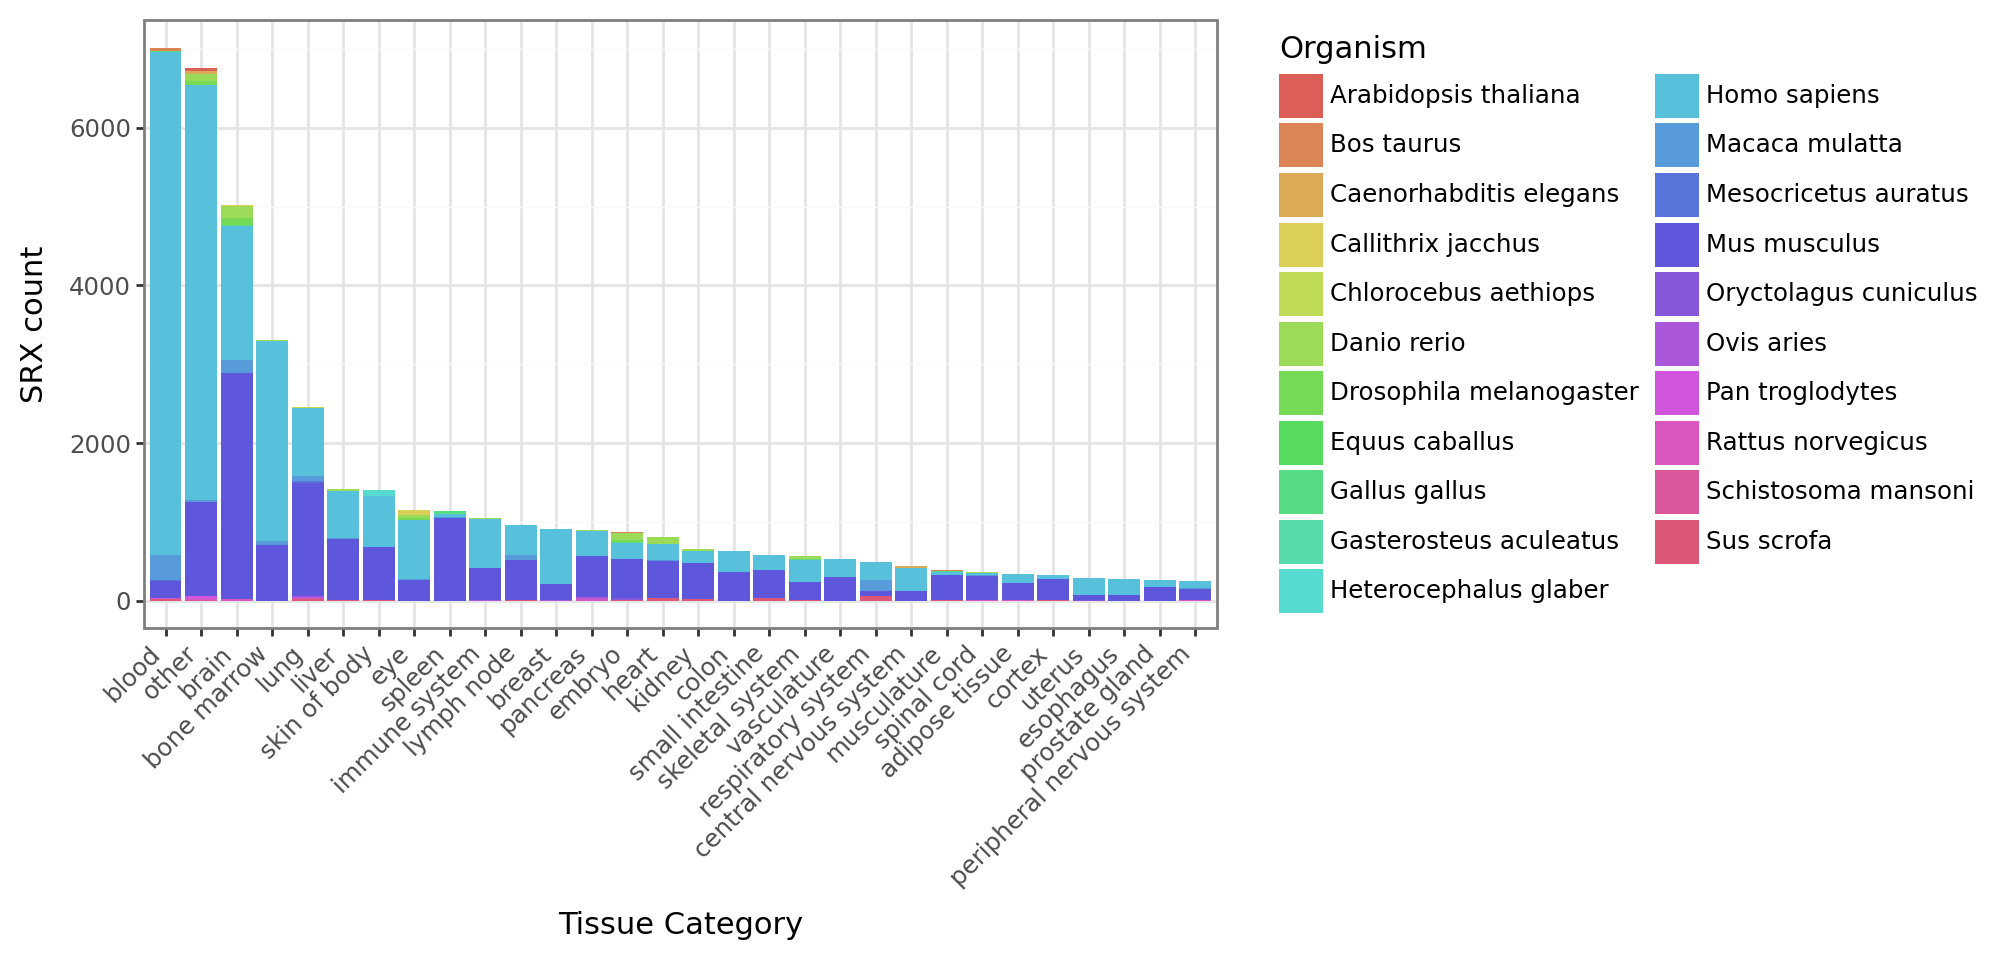

In [30]:
# plot histogram of tissue categories
## filter to top 30 categories
top30 = df_srx_meta["category"].value_counts().head(30).index
df = df_srx_meta[df_srx_meta["category"].isin(top30)].copy()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(10, 4.8),
        legend_key_height=1,
    ) 
)
p

## Animals, except human and mouse

In [31]:
other_animals = ['Macaca mulatta',
 'Sus scrofa',
 'Gallus gallus',
 'Drosophila melanogaster',
 'Equus caballus',
 'Pan troglodytes',
 'Heterocephalus glaber',
 'Callithrix jacchus',
 'Danio rerio',
 'Bos taurus',
 'Caenorhabditis elegans',
 'Oryctolagus cuniculus',
 'Ovis aries',
 'Schistosoma mansoni',
 'Gorilla gorilla']
other_animals

['Macaca mulatta',
 'Sus scrofa',
 'Gallus gallus',
 'Drosophila melanogaster',
 'Equus caballus',
 'Pan troglodytes',
 'Heterocephalus glaber',
 'Callithrix jacchus',
 'Danio rerio',
 'Bos taurus',
 'Caenorhabditis elegans',
 'Oryctolagus cuniculus',
 'Ovis aries',
 'Schistosoma mansoni',
 'Gorilla gorilla']

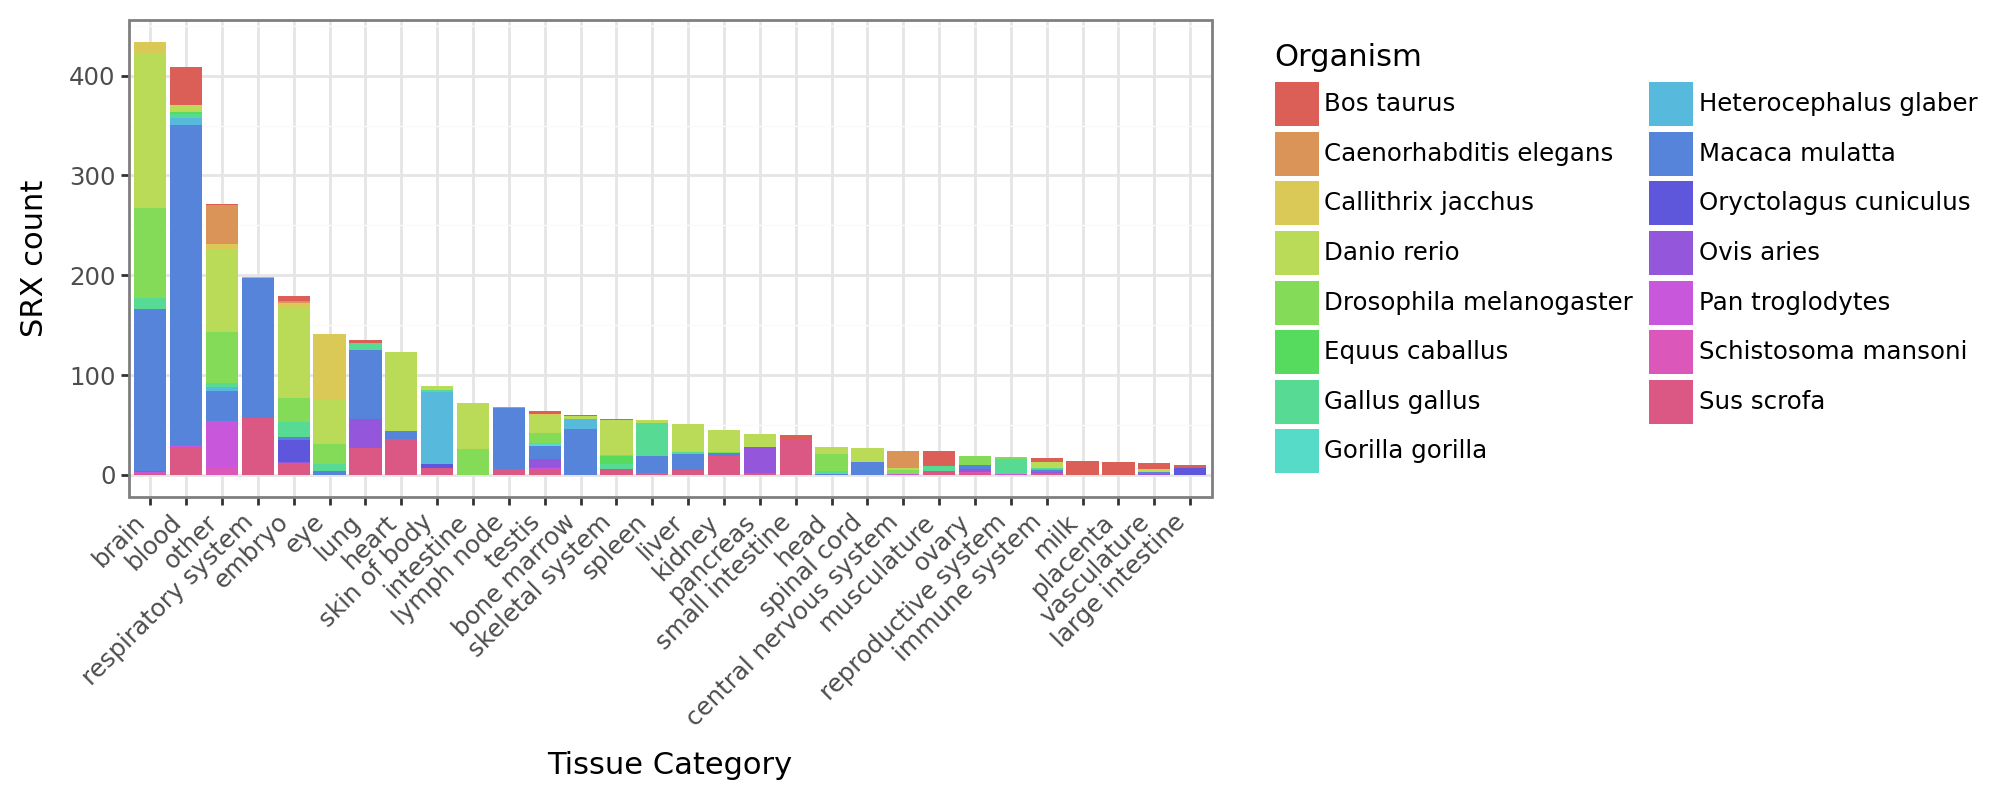

In [32]:
# plot histogram of tissue categories
## filter to target organisms
df = df_srx_meta[df_srx_meta["organism"].isin(other_animals)].copy()

## filter to top 30 categories
top30 = df["category"].value_counts().head(30).index
df = df[df["category"].isin(top30)]
df["category"] = df["category"].tolist()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(10, 4),
    ) +
    pn.guides(fill=pn.guide_legend(ncol=2))
)
p

## Just plants

In [33]:
plants = ["Arabidopsis thaliana", "Oryza sativa", "Solanum lycopersicum", "Zea mays"]

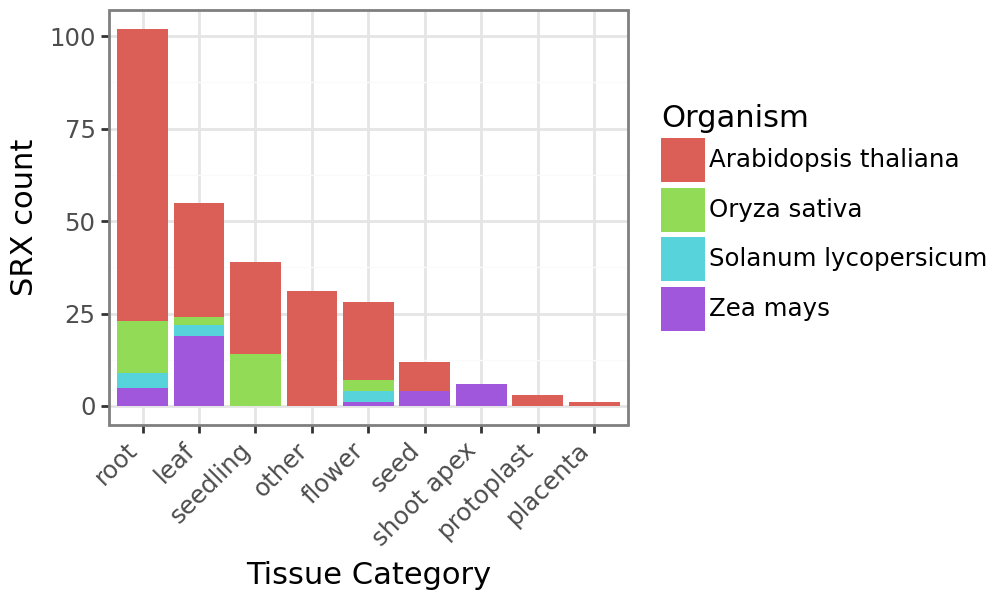

In [34]:
# plot histogram of tissue categories
## filter to plants
df = df_srx_meta[df_srx_meta["organism"].isin(plants)].copy()

## filter to top 30 categories
top30 = df["category"].value_counts().head(30).index
df = df[df["category"].isin(top30)]
df["category"] = df["category"].tolist()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(5, 3),
        legend_key_height=1,
    ) 
)
p

# session info

In [5]:
!conda list

# packages in environment at /home/nickyoungblut/miniforge3/envs/SRAgent_nb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
_python_abi3_support      1.0                  hd8ed1ab_2    conda-forge
aiobotocore               2.23.0             pyhd8ed1ab_0    conda-forge
aiohappyeyeballs          2.6.1              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.14                  pypi_0    pypi
aioitertools              0.12.0             pyhd8ed1ab_1    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.4             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0                    pypi_0    pypi
anthropic                 0.57.1                   pypi_0    pypi
anyio                     4.9.0                    pypi_0    pypi
appdir